# Tutorial 1: Two-omics integration (RNA and H3K27ac)

### This tutorial demonstrates STAOmics’s ablility to integrate two unpaired P22 mouse brain slices: RNA and H3K27ac. The raw and processed data can be downloaded from GSE205055 and https://drive.google.com/drive/folders/1_V4IAxblPzNVj6P53PWjVO07lQLn2gIy?usp=sharing, respectively.

In [1]:
import warnings
warnings.filterwarnings('ignore')

## setting for bedtools calling in jupyter
import os
from os import path
import sys
bin_dir = path.dirname(sys.executable)
os.environ['PATH'] += os.pathsep + bin_dir
# print(os.pathsep + bin_dir)

import pandas as pd
import anndata as ad
import networkx as nx
import scanpy as sc
import STAOmics
import numpy as np
import scipy.sparse as sp
from itertools import chain

STAOmics.config.BEDTOOLS_PATH = "/mnt/disk4/xzhou/anaconda3/envs/STAOmics/bin/"

## Step 1: Data preprocessing

In [2]:
datadir = '/mnt/disk2/xzhou/code/pycharm_ATAC/STAOmics_v0/data/P22/'

stH3K27ac = sc.read_h5ad(datadir+'P22_H3K27ac_cuttag.h5ad')
strna = sc.read_h5ad(datadir+'P22_H3K27ac_RNA.h5ad')

Raw counts are saved for the decoders which were fitted in the original feature spaces

In [3]:
strna.layers['counts'] = strna.X.astype(int).copy()
stH3K27ac.layers['counts'] = stH3K27ac.X.astype(int).copy()

### Preprocess spRNA-seq data

In [4]:
sc.pp.highly_variable_genes(strna, n_top_genes=3000, flavor="seurat_v3")
strna.var['highly_variable'].sum()

3000

In [5]:
sc.pp.normalize_total(strna) #, target_sum=1e4
sc.pp.log1p(strna)
strna = strna[:, strna.var['highly_variable']]
strna.obsm['X_feat'] = strna.X.toarray()

### Preprocess spCUT&Tag-seq data

In [6]:
stH3K27ac.obsm['X_lsi'] = STAOmics.utils.Epigenome_preprocess(stH3K27ac.copy(), key='X_lsi')

### Prior feature graph construction

We use genomic proximity between ATAC/CUT&Tag peaks and genes as prior information.

For spRNA-seq data, we extract genomic coordinates for gene names. The GTF file used here can be downloaded from [GENCODE](ftp://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_mouse/release_M25/gencode.vM25.chr_patch_hapl_scaff.annotation.gtf.gz) or [here](https://drive.google.com/file/d/1sHA15AAuwieKfukjuXcTKe4UrKVunRn3/view?usp=sharing).

In [7]:
STAOmics.data.get_gene_annotation(
    strna, gtf=datadir+"gencode.vM25.chr_patch_hapl_scaff.annotation.gtf.gz",
    gtf_by="gene_name"
)
strna.var.loc[:, ["chrom", "chromStart", "chromEnd"]].head()

strna = strna[:, ~strna.var['chrom'].isna()]

In [8]:
strna.var.loc[:, ["chrom", "chromStart", "chromEnd"]].head()

,chrom,chromStart,chromEnd
Ppp1r14c,chr10,3366056.0,3464975.0
Mthfd1l,chr10,3973117.0,4167081.0
Vip,chr10,5639217.0,5647617.0
Cnksr3,chr10,7119062.0,7212237.0
Nup43,chr10,7667502.0,7678881.0


For spCUT&Tag or spATAC-seq data, we extract genomic coordinates from `var_names` in adata. 

In [9]:
split = stH3K27ac.var_names.str.split(r"[:-]")
stH3K27ac.var["chrom"] = split.map(lambda x: x[0])
stH3K27ac.var["chromStart"] = split.map(lambda x: x[1]).astype(int)
stH3K27ac.var["chromEnd"] = split.map(lambda x: x[2]).astype(int)
stH3K27ac.var.head()

,chrom,chromStart,chromEnd
chr1-3094679-3094964,chr1,3094679,3094964
chr1-3119499-3119936,chr1,3119499,3119936
chr1-3121345-3121681,chr1,3121345,3121681
chr1-3250538-3251680,chr1,3250538,3251680
chr1-3263733-3264531,chr1,3263733,3264531


The genomic coordinates of the two omics features are used to construct the prior feature guidance graph. By default, an ATAC/CUT&Tag peak is connected to a gene if they overlap in either the gene body or promoter region. By setting `propagate_highly_variable = True`, highly variable genes will been propagated to the ATAC/CUT&Tag domain, by marking peaks reachable from the highly variable genes in the guidance graph. The guidance graph does not have edges within a modality, only cross-modality edges or self-loops.

In [10]:
guidance = STAOmics.genomics.rna_anchored_guidance_graph(strna, stH3K27ac, propagate_highly_variable = True)

window_graph: 100%|██████████| 2766/2766 [00:00<00:00, 3791.89it/s]


We can verify that the obtained guidance graph complies to all of the previous standards.

In [11]:
STAOmics.graph.check_graph(guidance, [strna, stH3K27ac])

[INFO] check_graph: Checking variable coverage...
[INFO] check_graph: Checking edge attributes...
[INFO] check_graph: Checking self-loops...
[INFO] check_graph: Checking graph symmetry...
[INFO] check_graph: All checks passed!


In [12]:
strna.var['highly_variable'].sum()

2766

In [13]:
nx.write_graphml(guidance, datadir+"P22_two_omics_guidance_RNA_H3K27ac.graphml.gz")

strna.write(datadir+"P22_two_omics_RNA_pp.h5ad", compression="gzip")
stH3K27ac.write(datadir+"P22_two_omics_H3K27ac_pp.h5ad", compression="gzip")

## Step 2: Model training

In [14]:
strna = ad.read_h5ad(datadir+"P22_two_omics_RNA_pp.h5ad")
stH3K27ac = ad.read_h5ad(datadir+"P22_two_omics_H3K27ac_pp.h5ad")
guidance = nx.read_graphml(datadir+"P22_two_omics_guidance_RNA_H3K27ac.graphml.gz")

strna.X = sp.csr_matrix(strna.X)
stH3K27ac.X = sp.csr_matrix(stH3K27ac.X)

strna.obs_names = strna.obs_names+'_RNA'  ### avoid same spot names between two slices
stH3K27ac.obs_names = stH3K27ac.obs_names+'_H3K27ac'

In [15]:
# Constructing the spatial neighbor network
STAOmics.utils.Cal_Spatial_Net(strna, rad_cutoff=1.3)  # the spatial network are saved in adata.uns[‘adj’]
STAOmics.utils.Cal_Spatial_Net(stH3K27ac, rad_cutoff=1.3)
# STAOmics.utils.Stats_Spatial_Net(stH3K27ac)

------Calculating spatial graph...
The graph contains 37084 edges, 9370 cells.
3.9577 neighbors per cell on average.
------Calculating spatial graph...
The graph contains 37084 edges, 9370 cells.
3.9577 neighbors per cell on average.


In [16]:
## only highly_variable features are used
guidance_hvf = guidance.subgraph(chain(
    strna.var.query("highly_variable").index,
    # scatac.var.index
    stH3K27ac.var.query("highly_variable").index
)).copy()
vertices = sorted(guidance_hvf.nodes)

#### Dataset configure

Before model training, we need to configure the datasets using STAOmics.models.configure_dataset. For each dataset to be integrated, we need to specify a probabilistic generative model. Here we model the raw counts of both spRNA-seq and spATAC-seq/spCUT&Tag-seq using the negative binomial distribution ("NB").

Optionally, we can specify whether only the highly variable features should be used (use_highly_variable), what data layer to use (use_layer), as well as what preprocessing embedding (use_rep) to use as first encoder transformation "use_obs_names=True" is used to construct cross-omics anchors identified by optimal transport.

In [17]:
STAOmics.models.configure_dataset(strna, "NB", use_highly_variable=True, use_rep="X_feat", use_layer="counts",  use_obs_names=True) 
STAOmics.models.configure_dataset(stH3K27ac, "NB", use_highly_variable=True, use_rep="X_lsi", use_layer="counts", use_obs_names=True) 

In [18]:
model = STAOmics.models.train(
    {"RNA": strna, "H3K27ac": stH3K27ac}, guidance_hvf,
    fit_kws={"directory": "P22_H3K27ac_v0"}, is_finetune = True, OT_pair=[('RNA','H3K27ac')]    ### compile_kws={"lam_align": 0.05}
)

[INFO] train: Pretraining STAOmics model...2025-06-24 20:23:01
[INFO] autodevice: Using GPU 1 as computation device.
[INFO] check_graph: Checking variable coverage...
[INFO] check_graph: Checking edge attributes...
[INFO] check_graph: Checking self-loops...
[INFO] check_graph: Checking graph symmetry...
[INFO] STAOmicsModel: Setting `graph_batch_size` = 14631
[INFO] STAOmicsModel: Setting `max_epochs` = 183
[INFO] STAOmicsModel: Setting `patience` = 16
[INFO] STAOmicsModel: Setting `reduce_lr_patience` = 8
[INFO] STAOmicsTrainer: Using training directory: "P22_H3K27ac_v0/pretrain"
[INFO] STAOmicsTrainer: [Epoch 10] train={'g_nll': 0.457, 'g_kl': 0.009, 'g_elbo': 0.465, 'x_RNA_nll': 0.263, 'x_RNA_kl': 0.005, 'x_RNA_elbo': 0.268, 'x_H3K27ac_nll': 0.092, 'x_H3K27ac_kl': 0.001, 'x_H3K27ac_elbo': 0.093, 'dsc_loss': 0.687, 'vae_loss': 0.385, 'gen_loss': 0.351, 'cos_loss': 0.0, 'gate_rec_loss': 5.731}, val=None, 10.1s elapsed
[INFO] STAOmicsTrainer: [Epoch 20] train={'g_nll': 0.42, 'g_kl': 0.

2025-06-24 20:39:41,986 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


[INFO] EarlyStopping: Restoring checkpoint "81"...
[INFO] EarlyStopping: Restoring checkpoint "81"...
[INFO] train: FGW OT mapping from source RNA to H3K27ac
[INFO] train: downsample source data to 5000...
[INFO] train: downsample target data to 5000...
How many source profiles were paired to an destination profile of the same cluster type: 0.9338
[INFO] train: Fine-tuning STAOmics model...2025-06-24 20:43:29
[INFO] check_graph: Checking variable coverage...
[INFO] check_graph: Checking edge attributes...
[INFO] check_graph: Checking self-loops...
[INFO] check_graph: Checking graph symmetry...
[INFO] STAOmicsModel: Setting `graph_batch_size` = 14631
[INFO] STAOmicsModel: Setting `align_burnin` = 34
[INFO] STAOmicsModel: Setting `max_epochs` = 200
[INFO] STAOmicsModel: Setting `patience` = 17
[INFO] STAOmicsModel: Setting `reduce_lr_patience` = 9
[INFO] STAOmicsTrainer: Using training directory: "P22_H3K27ac_v0/fine-tune"
[INFO] STAOmicsTrainer: [Epoch 10] train={'g_nll': 0.393, 'g_kl':

2025-06-24 20:57:49,263 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


[INFO] EarlyStopping: Restoring checkpoint "76"...
[INFO] EarlyStopping: Restoring checkpoint "76"...
[INFO] train: End of training...2025-06-24 20:57:49


In [19]:
strna.obsm["X_STAOmics"] = model.encode_data_minibatch("RNA", strna)
stH3K27ac.obsm["X_STAOmics"] = model.encode_data_minibatch("H3K27ac", stH3K27ac)

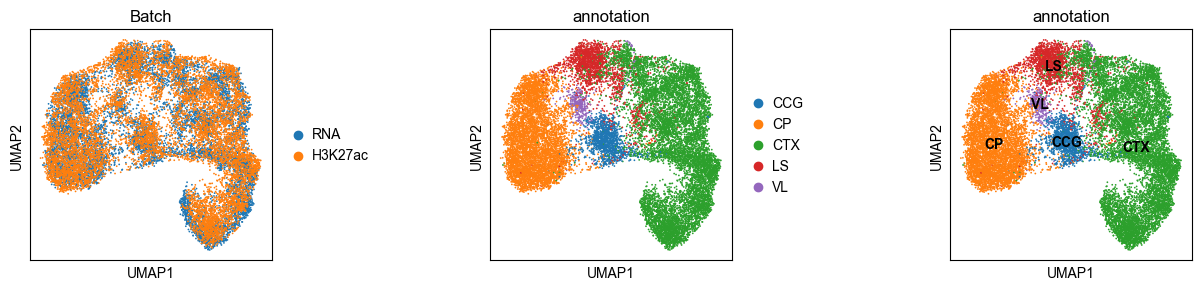

In [20]:
combined = ad.concat([strna, stH3K27ac], label='Batch', keys=['RNA','H3K27ac'],join='outer')
sc.pp.neighbors(combined, use_rep="X_STAOmics", metric="cosine")
sc.tl.umap(combined)

import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = "Arial"
plt.rcParams["figure.figsize"] = (2, 2)
plt.rcParams['font.size'] = 10
plt.rcParams['legend.handletextpad'] = 0.01
fig, ax = plt.subplots(1, 3, figsize=(15, 3), gridspec_kw={'wspace': 0.9, 'hspace': 0.1})

sc.pl.umap(combined, color=["Batch"], wspace=1, legend_fontsize=10, show=False, ax=ax[0])
sc.pl.umap(combined, color=['annotation'], legend_fontsize=10, show=False, ax=ax[1])   #, legend_loc=None
sc.pl.umap(combined, color=['annotation'], legend_fontsize=10, show=False, ax=ax[2], legend_loc='on data')
plt.show()

In [21]:
sc.tl.leiden(combined, random_state=666, key_added="leiden", resolution=1.3) 

strna.obs['leiden'] = combined.obs['leiden'][combined.obs['Batch']=='RNA'].values
stH3K27ac.obs['leiden'] = combined.obs['leiden'][combined.obs['Batch']=='H3K27ac'].values

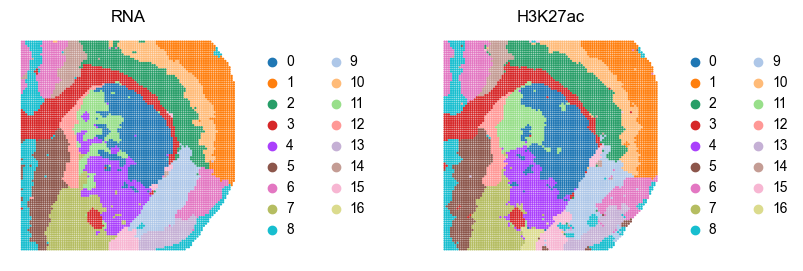

In [22]:
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = "Arial"
plt.rcParams["figure.figsize"] = (3, 3)
plt.rcParams['font.size'] = 10
plt.rcParams['legend.handletextpad'] = 0.01
# plt.rcParams['legend.labelspacing'] = 0.1 

spot_size = 30
fig, ax = plt.subplots(1, 2, figsize=(10, 3), gridspec_kw={'wspace': 0.2, 'hspace': 0.1})

spot_size = 1.1 
sc.pl.spatial(strna, color='leiden', cmap="viridis", show=False, frameon=False, spot_size=spot_size, title=['RNA'], ax=ax[0])
sc.pl.spatial(stH3K27ac, color='leiden', cmap="viridis", show=False, frameon=False, spot_size=spot_size,title=['H3K27ac'], ax=ax[1])
plt.show()